<a href="https://colab.research.google.com/github/Mohammedsameer1/First-Contribution/blob/master/FinalAssignment_GoStock_India_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

In [ ]:
# Function to scrape CNBC website for headlines
def scrape_cnbc_headlines():
    url = "https://www.cnbc.com/search/?query=green%20hydrogen&qsearchterm=green%20hydrogen"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    headlines = []
    news_dates = []
    for article in soup.find_all('div', class_='SearchResultCard'):
        headline = article.find('h3', class_='Card-title').text.strip()
        date_str = article.find('time', class_='datestamp')['datetime']
        news_date = datetime.strptime(date_str, "%Y-%m-%d")
        headlines.append(headline)
        news_dates.append(news_date)
    return headlines, news_dates

In [ ]:
# Function to get news headlines using Google News RSS feed
def get_google_news_headlines():
    url = "https://news.google.com/rss/search?q=green%20hydrogen&hl=en-IN&gl=IN&ceid=IN:en"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'xml')
    items = soup.find_all('item')
    headlines = []
    news_dates = []
    for item in items:
        headline = item.title.text
        pub_date = datetime.strptime(item.pubDate.text, "%a, %d %b %Y %H:%M:%S %Z")
        headlines.append(headline)
        news_dates.append(pub_date)
    return headlines, news_dates

In [ ]:
#Scrape CNBC headlines
cnbc_headlines, cnbc_dates = scrape_cnbc_headlines()

In [ ]:
# Get Google News headlines
google_news_headlines, google_news_dates = get_google_news_headlines()

In [ ]:
#Combine headlines and dates
headlines = cnbc_headlines + google_news_headlines
dates = cnbc_dates + google_news_dates


In [ ]:
# Create DataFrame
df = pd.DataFrame({'Source': ['CNBC'] * len(cnbc_headlines) + ['Google News'] * len(google_news_headlines),
                       'Headline': headlines,
                       'Date': dates})


In [ ]:
#Save DataFrame to CSV
df.to_csv('news_headlines.csv', index=False)
if __name__ == "__main__":main()

In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [ ]:
#Upload credentials.json file first
#
#from google.colab import files
#uploaded = files.upload()

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Define the scope and credentials
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
#Here My Credentials File is sheets-editor-account-4d3dea799afe.json.
credentials = ServiceAccountCredentials.from_json_keyfile_name('sheets-editor-account-4d3dea799afe.json', scope)

# Authorize the client
client = gspread.authorize(credentials)

# Open the Google Sheet (create it if it doesn't exist)
sheet = client.create('Sheet1')  # Replace 'News Headlines' with your desired sheet name

# Read the CSV file into a DataFrame
df = pd.read_csv('news_headlines.csv')

# Convert DataFrame to a list of lists
values = df.values.tolist()

# Select the first worksheet
worksheet = sheet.get_worksheet(0)

# Append the values to the worksheet
worksheet.append_rows(values)

# Share the Google Sheet with "Anyone with the link" access
sheet.share('', perm_type='anyone', role='reader')

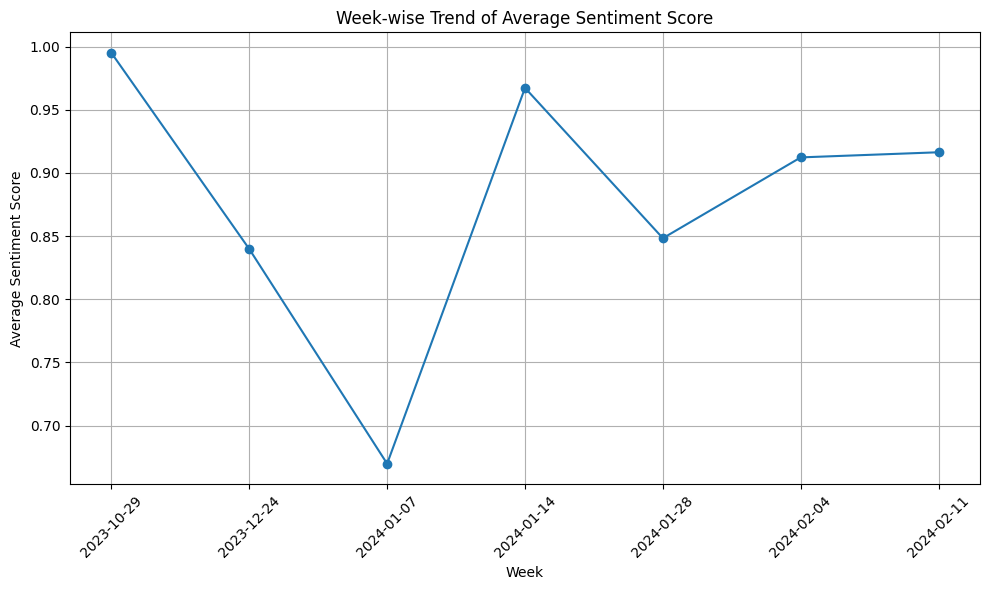

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Load the CSV table containing news Date, headline, source and Sentiment_Score As i created this file seperately because the news_headline.csv has
#to be converted into Google sheets so that file contains only three columns , News Date,Headline and source . so i doesn't contains Sentiment_Score
#so for that to find (Week-wise Trend of Average sentiment ), i converted my existing Df(DataFrame ) into this "news_headlines_with_sentiment (1).cs" this
# file So , Maybe you confused where this comes so this is the explanation for that.
df = pd.read_csv('news_headlines_with_sentiment (1).csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate sentiment score (this part assumes you already have sentiment scores in the DataFrame)
# df['Sentiment Score'] = ... (calculate sentiment score here)

# Group by week and calculate the average sentiment score
df['Week'] = df['Date'].dt.to_period('W')
weekly_avg_sentiment = df.groupby('Week')['Sentiment Score'].mean()

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(weekly_avg_sentiment.index.strftime('%Y-%m-%d'), weekly_avg_sentiment.values, marker='o')
plt.title('Week-wise Trend of Average Sentiment Score')
plt.xlabel('Week')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pip install wordcloud transformers

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


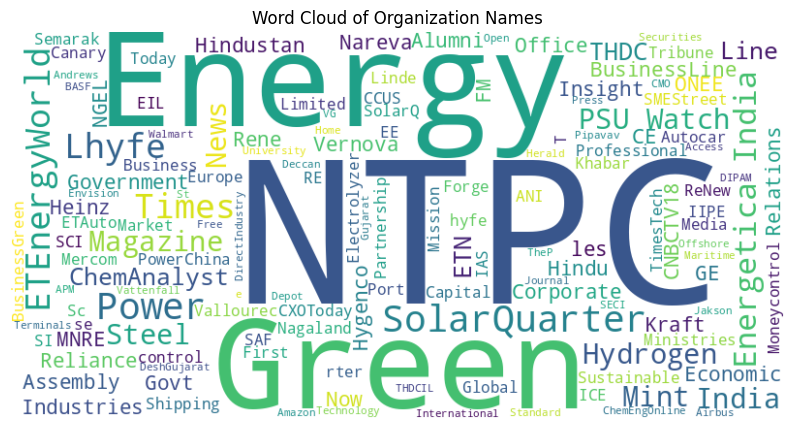

In [ ]:
import pandas as pd
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('news_headlines_with_sentiment (1).csv')

# Initialize the NER pipeline for entity recognition
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", grouped_entities=True)

# Function to extract organization names using NER
def extract_organization_names(text):
    entities = ner_pipeline(text)
    organization_names = [entity['word'] for entity in entities if entity['entity_group'] == 'ORG']
    return organization_names

# Extract organization names from each text entry in the CSV file
all_organization_names = []
for text in df['Headline']:
    organization_names = extract_organization_names(text)
    all_organization_names.extend(organization_names)

# Process the extracted organization names as needed (e.g., filtering, deduplication)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_organization_names))

# Visualize the organization names using a word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Organization Names')
plt.axis('off')
plt.show()